# Import Libraries

In [1]:
import os # Library for accessing the file system
import cv2 # Library for image processing
import matplotlib.pyplot as plt # Library for data visualization
import numpy as np # Library for numerical computations
import pandas as pd # Library for data manipulation and analysis
from tqdm import tqdm # Library for progress bar
from keras.applications import MobileNetV2 # Pre-trained CNN model
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input # Layers for building neural network
from keras.models import Model # Framework for building neural network
from keras.optimizers import Adam # Optimizer for gradient descent
from keras.preprocessing.image import ImageDataGenerator # Utility for loading images and performing data augmentation
from keras_preprocessing.image import array_to_img # Library to convert NumPy array to a PIL.Image.Image object
from keras.utils import to_categorical, load_img, img_to_array # Utility for converting labels to categorical values, etc
from sklearn.preprocessing import LabelEncoder # Utility for encoding labels
from sklearn.metrics import classification_report, confusion_matrix # Utility for evaluating model performance
from sklearn.model_selection import train_test_split # Utility for splitting data into training and testing sets
import seaborn as sns # Library for data visualization

# Data Analysis

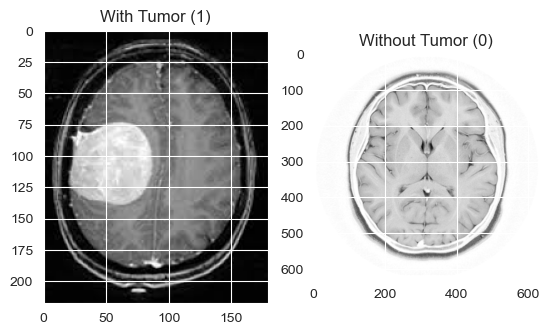

In [2]:
# Define the path to the dataset
dataset_path = "./brain_tumor_dataset"

# Load MRI images
image1 = plt.imread('./brain_tumor_dataset/yes/Y1.jpg')
image2 = plt.imread('./brain_tumor_dataset/no/1 no.jpeg')

# Display images side by side
fig, ax = plt.subplots(1, 2) # create a figure with one row and two columns of subplots
ax[0].imshow(image1, cmap='binary') # show the first image on the first subplot
ax[0].set_title('With Tumor (1)') # set the title of the first subplot
ax[1].imshow(image2, cmap='binary') # show the second image on the second subplot
ax[1].set_title('Without Tumor (0)') # set the title of the second subplot
plt.show() # display the figure

# Data Preprocess

In [3]:
# Define the data augmentation object with the desired parameters
aug = ImageDataGenerator(
    # rotation_range=20,  # Reduce rotation range to avoid distorting brain structure
    # zoom_range=0.2,  # Reduce zoom range to avoid cropping important parts of the image
    # width_shift_range=0.2,  # Reduce horizontal shift range to avoid moving important structures out of frame
    # height_shift_range=0.2,  # Reduce vertical shift range to avoid moving important structures out of frame
    # shear_range=0.2,  # Reduce shear range to avoid distorting brain structure
    horizontal_flip=True, # Randomly flip the image horizontally
    vertical_flip=True, # Randomly flip the image vertically
    # fill_mode="nearest" # Fill any empty pixels created during the transformation with the nearest available pixel value.
)

In [4]:
# Initialize the hyperparameters
INIT_LR = 1e-4 # Learning rate
EPOCHS = 20 # Number of epochs
BS = 32 # Batch size

# Define train and test generators
aug_generator = aug.flow_from_directory(
    dataset_path,
    batch_size=BS,
    class_mode='binary',
    shuffle=False
)

# Save images from train generator with progress bar
for i in tqdm(range(len(aug_generator.filenames))):
    # Load the next image from the generator
    img_path = os.path.join(dataset_path, aug_generator.filenames[i])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Generate augmented images for the current image
    class_name = 'no' if aug_generator.labels[i] == 0 else 'yes'
    aug_images = aug.flow(x, batch_size=1, save_format='png')

    # Save each augmented image to the corresponding class directory
    for j in range(len(aug_images)):
        img_array = aug_images[j].reshape(aug_images[j].shape[1:])
        img = array_to_img(img_array)
        if class_name == 'no':
            img.save(os.path.join(dataset_path, class_name, f"{i}_0.png"))
        else:
            img.save(os.path.join(dataset_path, class_name, f"{i}_1.png"))

Found 253 images belonging to 2 classes.


100%|██████████| 253/253 [00:22<00:00, 11.22it/s]


In [5]:
# Load the image data and labels
data = [] # initialize empty list to store image data
labels = [] # initialize empty list to store corresponding labels

# Iterate through each category in ["no", "yes"]
for category in ["no", "yes"]:
    path = os.path.join(dataset_path, category) # set the path to the directory containing the images for this category
    for img in os.listdir(path): # iterate through each image file in the directory
        img_path = os.path.join(path, img) # set the full file path for the image
        image = cv2.imread(img_path) # read the image data into a numpy array
        image = cv2.resize(image, (224, 224)) # resize the image to (224,224)
        data.append(image) # add the image data to the list of data
        labels.append(category) # add the corresponding label to the list of labels

# Print the data and labels lists
print(data)
print(labels)

[array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,

In [6]:
# create an instance of the LabelEncoder class
le = LabelEncoder()

# transform the labels into numerical values using the fit_transform() method of the LabelEncoder object
labels = le.fit_transform(labels)

# print the resulting numerical values of the labels
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [7]:
# Convert the data and labels lists to NumPy arrays
data = np.array(data)   # convert the list 'data' to a NumPy array and store it in a variable called 'data'
labels = np.array(labels)   # convert the list 'labels' to a NumPy array and store it in a variable called 'labels'

# Print the NumPy arrays
print(data)   # print the NumPy array 'data'
print(labels)   # print the NumPy array 'labels'

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0

In [8]:
# Perform one-hot encoding on the labels
labels = to_categorical(labels)

# Print the one-hot encoded labels
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [9]:
# Split the data using the train_test_split function and store the results in variables
(trainX, testX, trainY, testY) = train_test_split(
    data, # dataset to be split
    labels, # corresponding labels
    test_size=0.2, # 20% of the data will be used for testing and 80% for training
    stratify=labels, # ensures that the ratio of classes in the original dataset is maintained in both the training and testing datasets
    random_state=None # set the random seed for reproducibility
)

# Model Development

In [10]:
# Load the MobileNetV2 network with pre-trained weights
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# View the baseModel summary
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [11]:
# Define the head of the model that will be placed on top of the base model
headModel = baseModel.output

# Add Average Pooling layer with a pool size of (7, 7) to the head model
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)

# Flatten the output of the previous layer and add a name to it
headModel = Flatten(name="flatten")(headModel)

# Add a fully connected Dense layer with 128 units and a ReLU activation function
headModel = Dense(128, activation="relu")(headModel)

# Add a Dropout layer with a rate of 0.5 to reduce overfitting
headModel = Dropout(0.75)(headModel)

# Add a fully connected Dense layer with 2 units and a softmax activation function
headModel = Dense(2, activation="softmax")(headModel)

In [12]:
# This code freezes the layers of a pre-trained base model, so that they will not be trained during fine-tuning.
# Loop through each layer in the base model
for layer in baseModel.layers:
    # Set the "trainable" attribute of the layer to False
    layer.trainable = False

# View the baseModel summary
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [13]:
# Create a new model with baseModel as input and headModel as output
model = Model(inputs=baseModel.input, outputs=headModel)

# Define the optimizer with the specified learning rate and decay
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

# Compile the model with the binary crossentropy loss function, the defined optimizer and the accuracy metric
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# View the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
# Train the model using augmented data
H = model.fit(
    trainX, trainY,
    steps_per_epoch=len(trainX) // BS, # Number of batches per epoch
    validation_data=(testX, testY), # Validation data
    validation_steps=len(testX) // BS, # Number of batches for validation
    epochs=EPOCHS # Number of training epochs
)

Epoch 1/20
12/12 [==============================] - 19s 786ms/step - loss: 1.0478 - accuracy: 0.5421 - val_loss: 0.6348 - val_accuracy: 0.6471
Epoch 2/20
12/12 [==============================] - 6s 553ms/step - loss: 0.9674 - accuracy: 0.5693 - val_loss: 0.6280 - val_accuracy: 0.6373
Epoch 3/20
12/12 [==============================] - 7s 564ms/step - loss: 0.7874 - accuracy: 0.6114 - val_loss: 0.5913 - val_accuracy: 0.6765
Epoch 4/20
12/12 [==============================] - 7s 579ms/step - loss: 0.7273 - accuracy: 0.6287 - val_loss: 0.5630 - val_accuracy: 0.7157
Epoch 5/20
12/12 [==============================] - 7s 591ms/step - loss: 0.6968 - accuracy: 0.6139 - val_loss: 0.5465 - val_accuracy: 0.7647
Epoch 6/20
12/12 [==============================] - 6s 551ms/step - loss: 0.6236 - accuracy: 0.6931 - val_loss: 0.5365 - val_accuracy: 0.7647
Epoch 7/20
12/12 [==============================] - 7s 604ms/step - loss: 0.5972 - accuracy: 0.7104 - val_loss: 0.5235 - val_accuracy: 0.7843
Epoch

In [15]:
# Make predictions on the test set
predictions = model.predict(testX)

# Convert the predicted probabilities to class labels
predictions = np.argmax(predictions, axis=1)

# Generate a classification report
report_dict = classification_report(testY.argmax(axis=1), predictions, target_names=le.classes_, output_dict=True)

# create a pandas DataFrame from the classification report dictionary
df = pd.DataFrame(report_dict)

print(df)

# save the DataFrame to a CSV file
df.to_csv('MNV2_Report.csv')

# Save the model
model.save("MNV2_Model.h5")

4/4 [==============================] - 4s 355ms/step
                  no        yes  accuracy   macro avg  weighted avg
precision   1.000000   0.784810  0.833333    0.892405      0.869198
recall      0.575000   1.000000  0.833333    0.787500      0.833333
f1-score    0.730159   0.879433  0.833333    0.804796      0.820894
support    40.000000  62.000000  0.833333  102.000000    102.000000


# Result Analysis

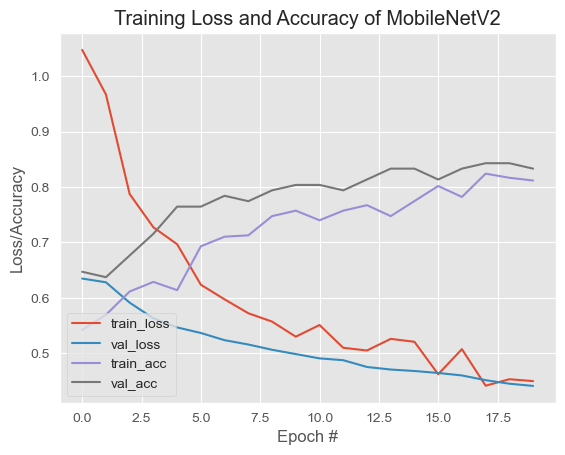

In [16]:
# This code plots the training loss and accuracy of the MobileNetV2 model.
# It uses the "ggplot" style for the plot.

# Set the style of the plot
plt.style.use("ggplot")

# Create a new figure
plt.figure()

# Add four plots to the figure: training loss, validation loss, training accuracy, and validation accuracy
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_acc")

# Set the title of the plot
plt.title("Training Loss and Accuracy of MobileNetV2")

# Add labels to the x and y axes of the plot
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")

# Add a legend to the plot in the lower left corner
plt.legend(loc="lower left")

# Save the plot as an image file
plt.savefig('MNV2_Loss_Accuracy.png')

# Display the plot on the screen
plt.show()

4/4 [==============================] - 2s 326ms/step


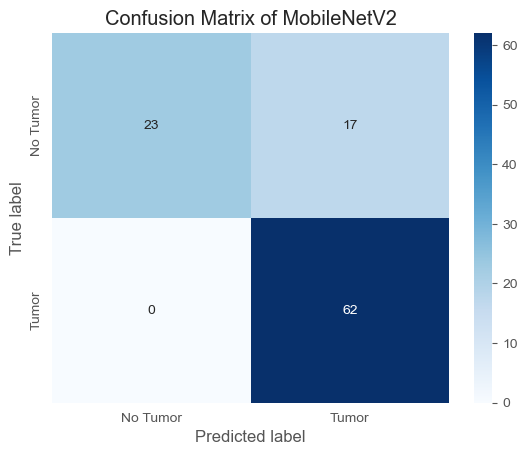

In [17]:
# This code plots the Confusion Matrix of the MobileNetV2 model.

# First, get the true and predicted labels
y_true = np.argmax(testY, axis=1)
y_pred = np.argmax(model.predict(testX), axis=1)

# Then, get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
class_names = ['No Tumor', 'Tumor']

# Create a heatmap using the confusion matrix, with annotations and blue color scheme
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# Add labels and title to the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix of MobileNetV2')

# Save the plot as an image file
plt.savefig('MNV2_Confusion_Matrix.png')

# Display the plot
plt.show()